# Feature Extraction

- Calculate KC frequency + analysis over population
- Wasserstein barycenter tests
- Extraction of KC features in parallel

In [1]:
!pip3 install torch torchvision torchaudio --quiet
!pip install gpytorch --quiet
!pip install mne --quiet
!pip install pandas --quiet
!pip install pywavelets --quiet
!pip install edfio --quiet
!pip install tqdm --quiet
!pip install pot --quiet
!pip install tslearn --quiet

### Imports

In [2]:
import os
import tqdm
import ot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from itertools import product
from multiprocessing import Pool
from tqdm import tqdm

import mne
from mne.stats.parametric import _parametric_ci
from mne import create_info
from mne.io import RawArray

from KC_algorithm.model import score_KCs
from KC_algorithm.utils import EpochData
from KC_algorithm.plotting import KC_from_probas, plot_all_Kcs

from utils.plots import plot_Kcs_in_single_chart, plot_Kcs_in_single_chart_epoch_data, plot_kcs_per_minute_and_sleep_stages, KC_from_probas_epoch_data
from utils.io import import_event_and_stages_SHHS, get_total_recording_time, store_kcs_data, load_kcs_edf_files, load_invalid_kc_metadata, load_valid_kc_metadata
from utils.preprocessing import remove_steady_epochs, remove_standard_deviation_outliers
from utils.postprocessing import calculate_kcs_per_minute, filter_kcs_by_sleep_stages

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

import matplotlib

Updated sk-learn import path


### Paths & Constants

In [4]:
DATASET_DIR = "/home/ec2-user/SageMaker/datasets/nsrr/shhs/"

# Get lists of all EDF and annotation files in their respective directories
edf_dir = os.path.join(DATASET_DIR, 'polysomnography/edfs/shhs1')
annot_dir = os.path.join(DATASET_DIR, 'polysomnography/annotations-events-nsrr/shhs1')
kcs_dir = os.path.join(DATASET_DIR, 'preprocessed/shhs1')
datasets_dir = os.path.join(DATASET_DIR, 'datasets')
datasets_dir_generated = os.path.join(DATASET_DIR, 'datasets-preprocessed')


edf_files = sorted([os.path.join(edf_dir, f) for f in os.listdir(edf_dir) if f.endswith('.edf')])
annot_files = sorted([os.path.join(annot_dir, f) for f in os.listdir(annot_dir) if f.endswith('-nsrr.xml')])

# Zip the edf and annotation files together
file_paths = list(zip(edf_files, annot_files))

# Individual datasets with population & events data
population_dataset = os.path.join(datasets_dir, 'shhs1-dataset-0.20.0.csv')
events_dataset = os.path.join(datasets_dir, 'shhs1-cvd-summary-dataset-0.20.0.csv')
variables_dataset = os.path.join(datasets_dir, 'shhs-data-dictionary-0.20.0-variables.csv')

# Datasets I calculate myself
density_dataset = os.path.join(datasets_dir_generated, 'enriched-avg-kc-density.csv')
kc_features_dataset = os.path.join(datasets_dir_generated, 'enriched-kc_features.csv')


# Load the datasets to make them globally available
population_df = pd.read_csv(population_dataset)
variables_df = pd.read_csv(variables_dataset)
# <- This is only calculated later in this Notebook but I still put it here.
# Comment out if run for the first time.
density_df = pd.read_csv(density_dataset)

# Constants
PROB_THRESHOLD = 0.5
SAMPLING_FREQ = 128
HIGHPASS_FILTER_CUTOFF = 0.3
STD_PREPROCESSING_CUTOFF = 3

POST_PEAK = 1.5
PRE_PEAK = 1.5

WANTED_CHANNEL = 'EEG'
WANTED_SLEEP_STAGES = [2, 3]

SLEEP_STAGE_TO_LABEL_DICT = {
    0: "Awake",
    1: "Sleep Stage 1", 
    2: "Sleep Stage 2", 
    3: "Sleep Stage 3",
    4: "Sleep Stage 4",
    5: "REM Sleep"
}

# Define the age category labels
AGE_LABELS = {
    5: '35-44 years',
    6: '45-54 years',
    7: '55-64 years',
    8: '65-74 years',
    9: '75-84 years',
    10: '85 years or older'
}

matplotlib.rcParams.update({
    'font.family': 'serif',
    'font.size' : 11,
})

### Tell Mne to only log errors

In [5]:
mne.set_log_level('ERROR')

### Load all KCs & calculate the frequency

In [6]:
def load_kc(index, vis=True):
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')
    
    print(valid_edf_output_dir)

    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
    
    print(valid_epochs_data_loaded.shape)

    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    print(f'Loaded {labels_valid.shape[0]} valid KCs')
    print(f'Loaded {labels_invalid.shape[0]} invalid KCs')


    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    # Optional: Here one could do another preprocessing
    filtered_onsets = onsets_combined[probas_combined > 0.7]

    if vis:
        ### Plot KCs by probabillity
        #KC_from_probas(C3*-1, onsets_valid, probas_valid, SAMPLING_FREQ)
        KC_from_probas_epoch_data(valid_epochs_data_loaded, onsets_valid, probas_valid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
            
        ### Plot valid KCs
        plot_Kcs_in_single_chart_epoch_data(valid_epochs_data_loaded, onsets_valid, probas_valid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot invalid KCs
        plot_Kcs_in_single_chart_epoch_data(invalid_epochs_data_loaded, onsets_invalid, probas_invalid, SAMPLING_FREQ, POST_PEAK, PRE_PEAK)
        
        ### Plot KCs per minute
        total_duration = get_total_recording_time(annot_filename)  # in seconds
        stages = import_event_and_stages_SHHS(annot_filename)[1]

        ### Find any KCs that are in the wrong sleep stage -> Meaning the preprocessing is wrong
        onsets_valid_cleaned, onsets_valid_outside = filter_kcs_by_sleep_stages(onsets_combined, stages, WANTED_SLEEP_STAGES, SAMPLING_FREQ)

        ### Now plot the KCs in the right sleep stage
        minutes, kcs_per_minute = calculate_kcs_per_minute(onsets_valid_cleaned, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes, kcs_per_minute, stages)


        ### And the KCs in the wrong sleep stage
        minutes_outside, kcs_per_minute_outside = calculate_kcs_per_minute(onsets_valid_outside, SAMPLING_FREQ, total_duration)
        plot_kcs_per_minute_and_sleep_stages(minutes_outside, kcs_per_minute_outside, stages)
        
        print(np.mean(kcs_per_minute))

/home/ec2-user/SageMaker/datasets/nsrr/shhs/preprocessed/shhs1/shhs1-200002/valid_kcs/edfs
(130, 384)
Loaded 130 valid KCs
Loaded 188 invalid KCs


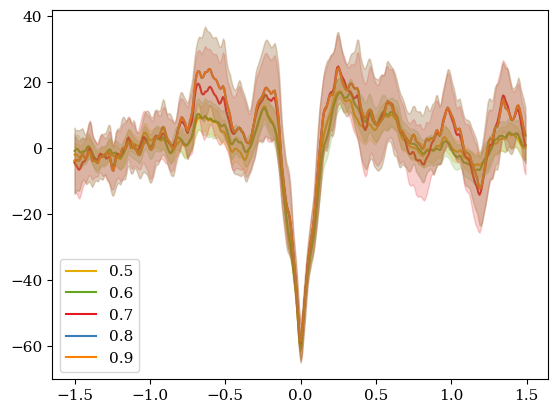

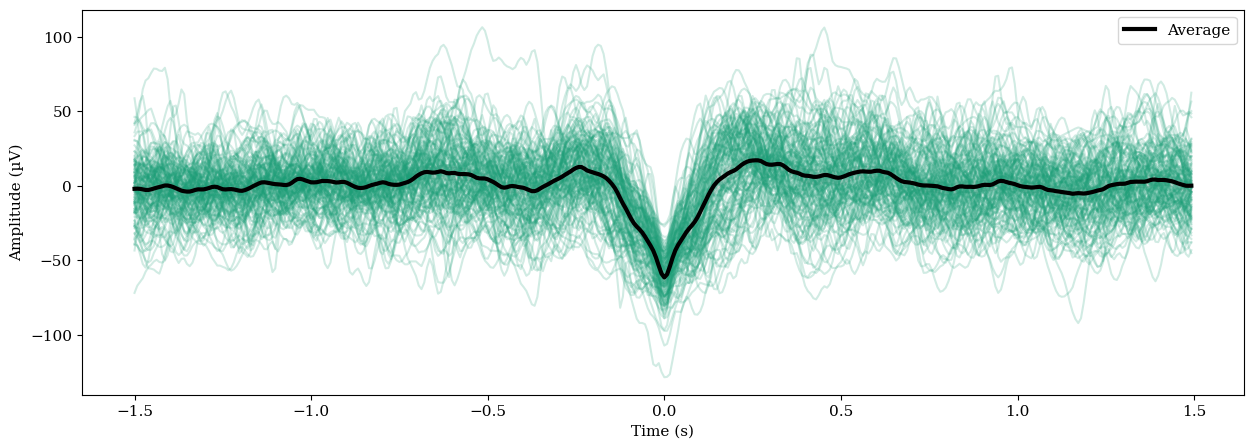

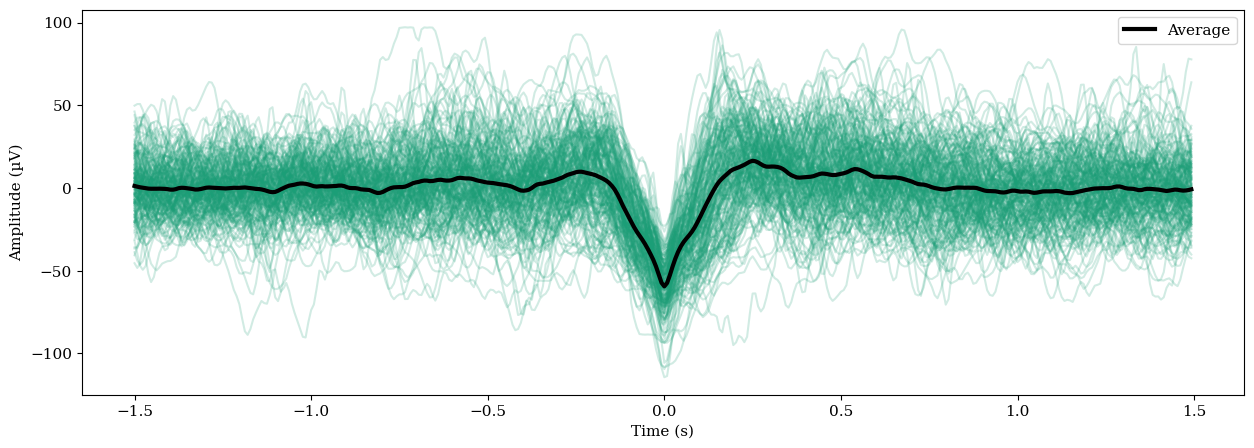

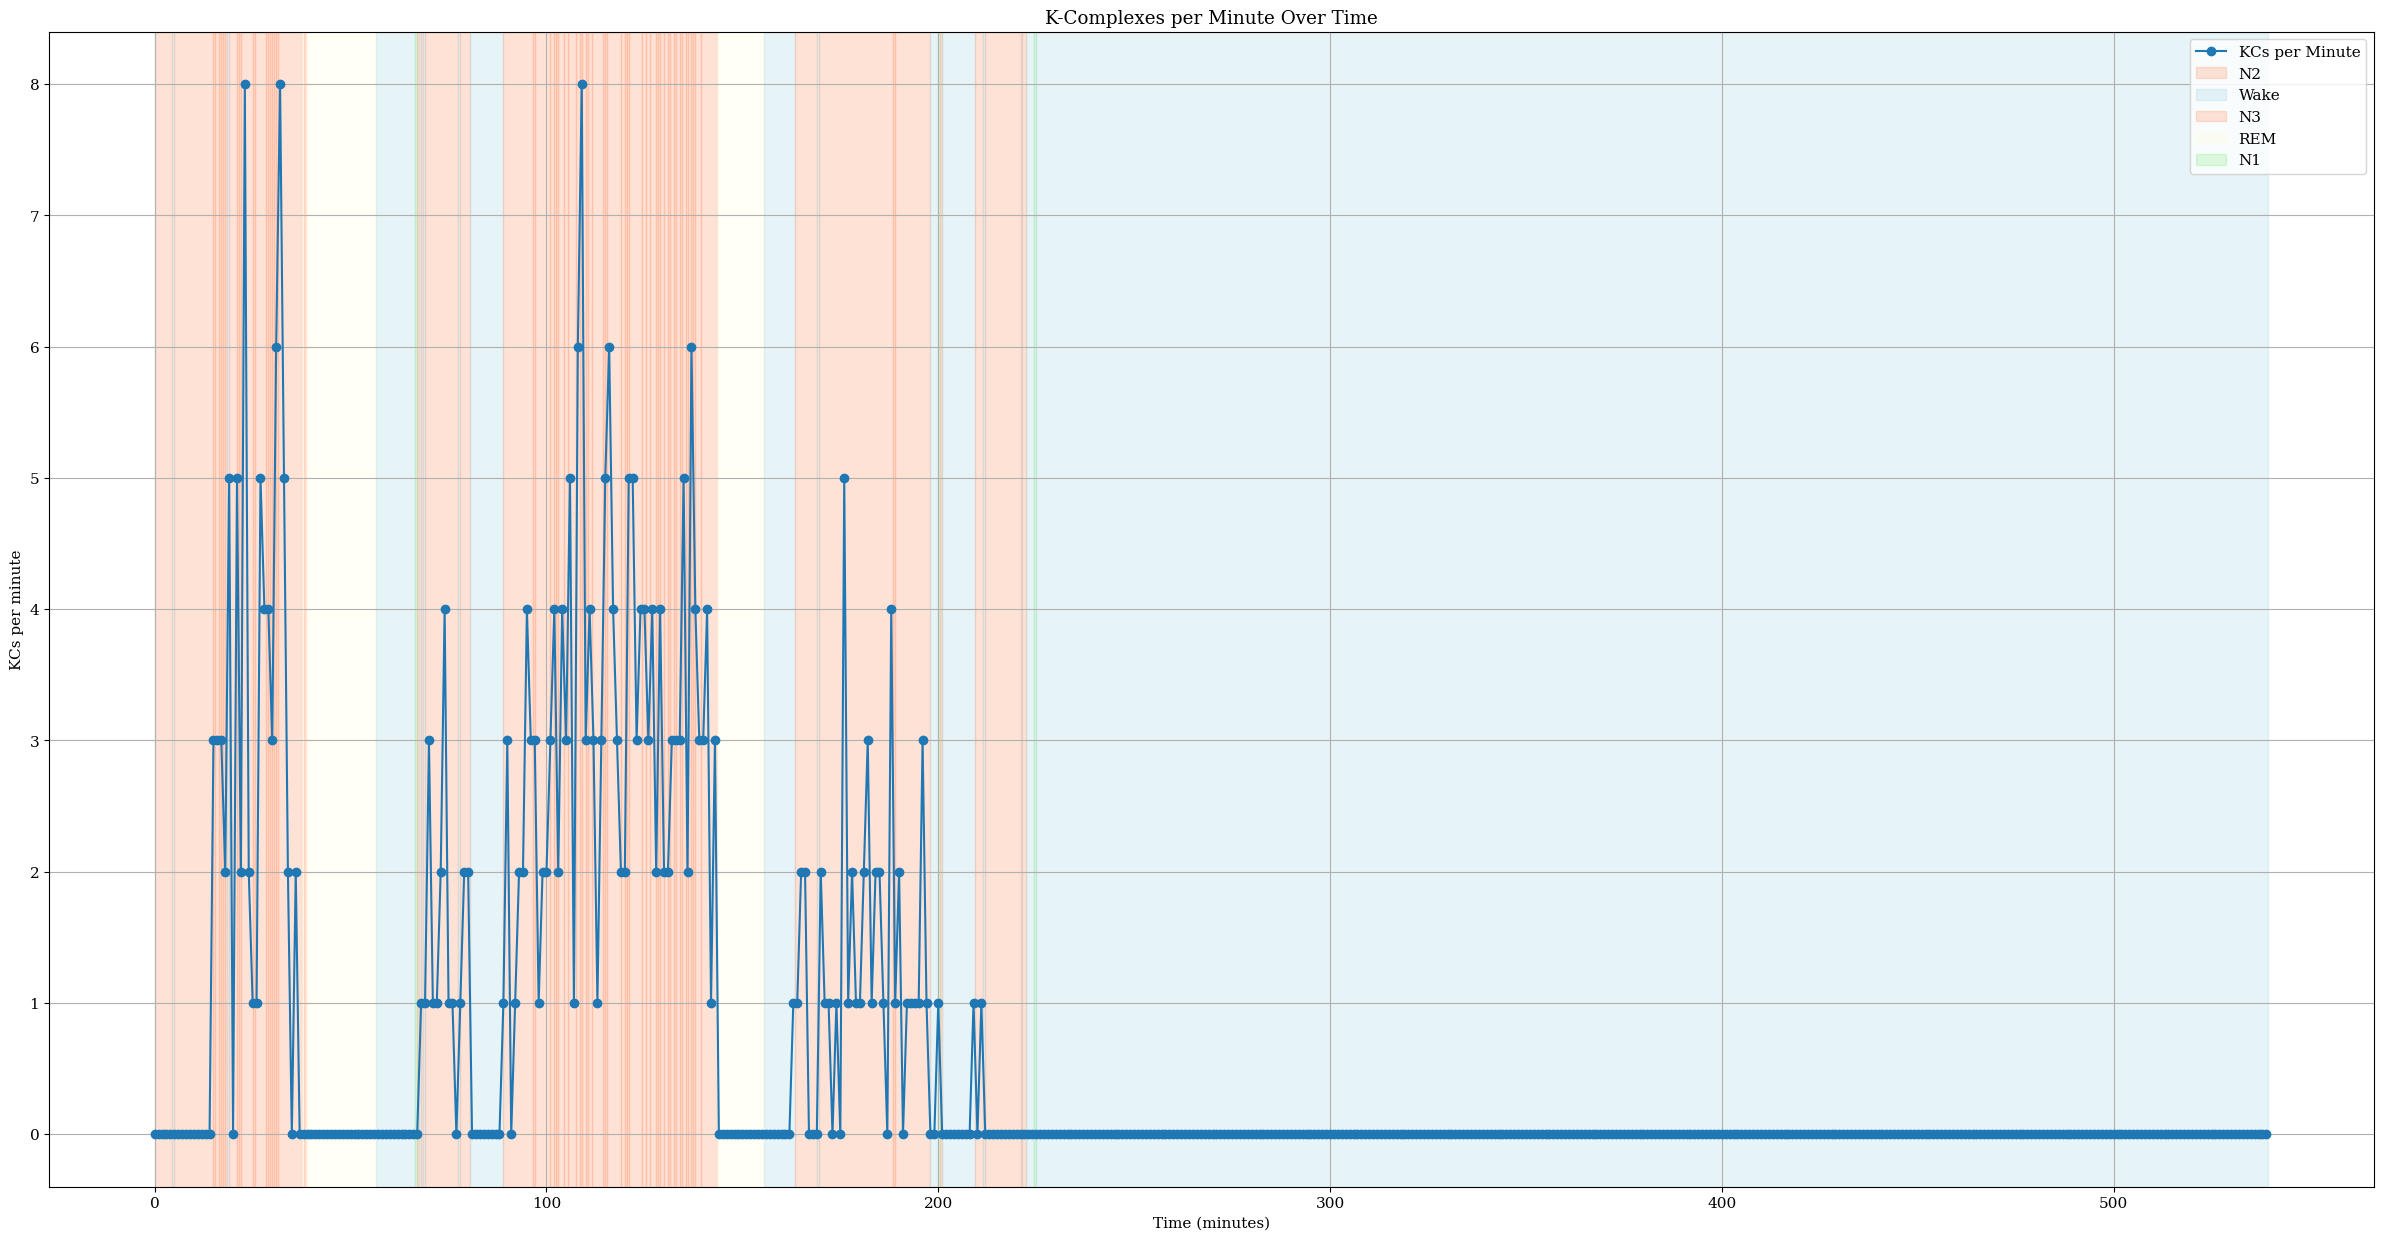

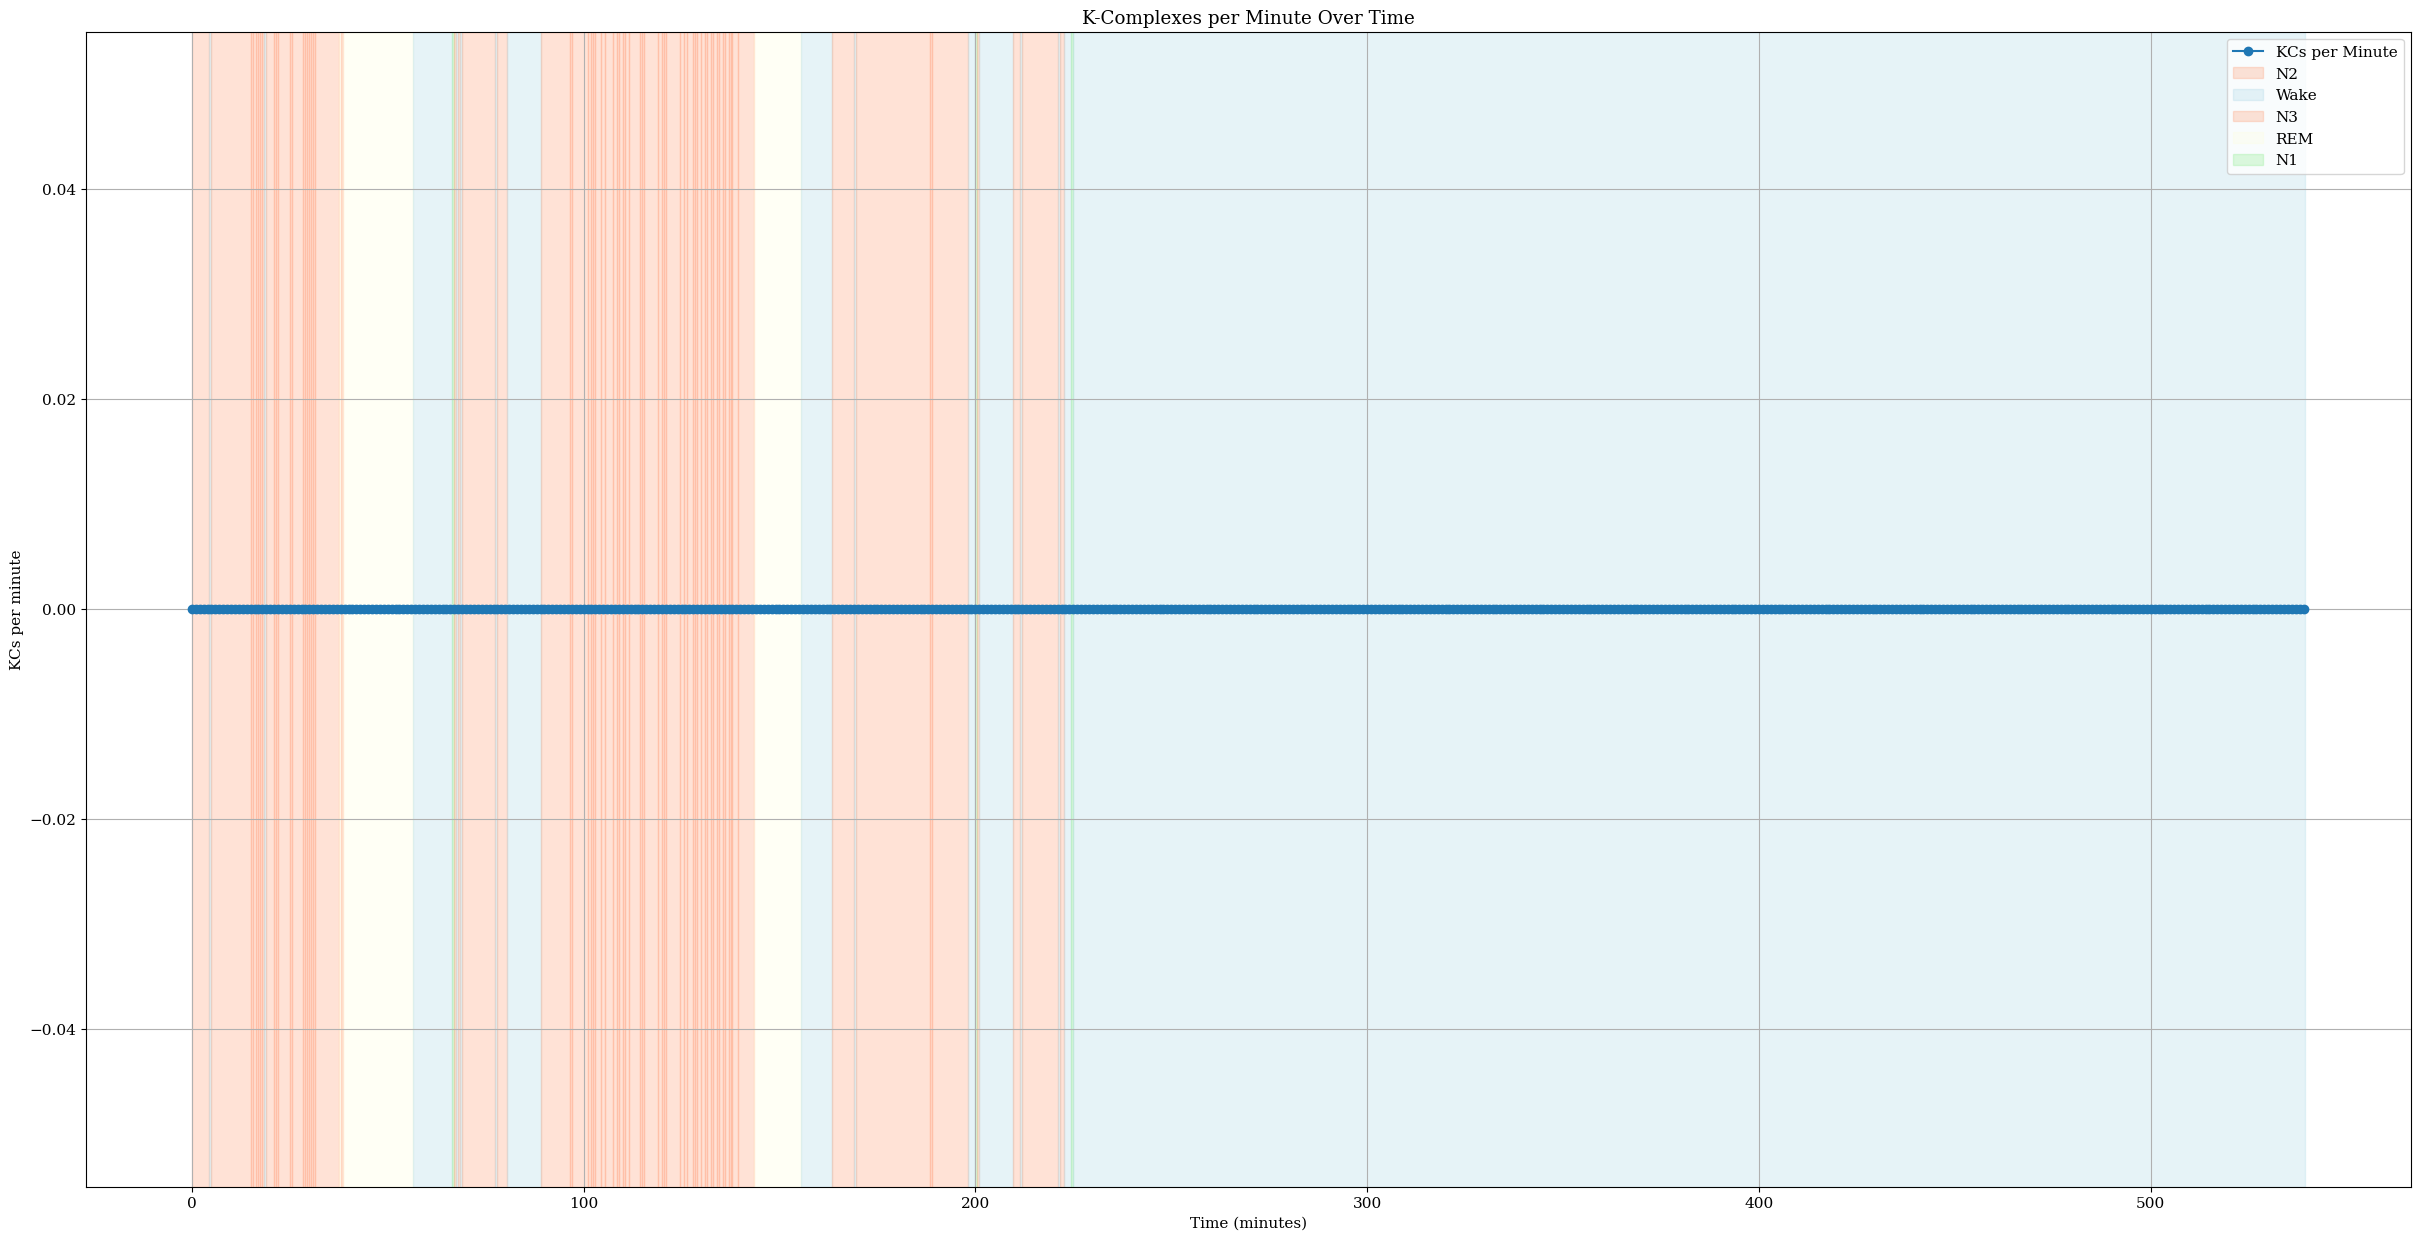

0.5888888888888889


In [7]:
index = 1
load_kc(index, vis=True)

### Explore Population

In [8]:
### Drop rows where no edf data is available
population_columns_of_interest = ["nsrrid", "bmi_s1", "gender", "height", "weight", "waist", "age_category_s1", "avgsat", "minsat", "ethnicity"]

population_selected_df = population_df[population_columns_of_interest]

valid_nsrrids = []

for path in file_paths:
    nssrid = os.path.basename(path[0]).replace('.edf', '').split("-")[1]
    valid_nsrrids.append(int(nssrid))

# Filter the dataframe to keep only the rows with nsrrid in valid_nsrrids
population_selected_df = population_selected_df[population_selected_df['nsrrid'].isin(valid_nsrrids)]
population_selected_df = population_selected_df.reset_index()

In [9]:
# Select a subset for faster testing
population_selected_df_subset = population_selected_df

#### Box Plot the Average KC/min by population characteristics

In [10]:
def filter_kcs_by_minutes_and_stages(minutes, kcs_per_minute, stages, valid_stages):
    """
    Filter the kcs_per_minute entries where the minutes are in sleep stages that are not valid.

    Parameters:
    - minutes (ndarray): Array of minute intervals.
    - kcs_per_minute (ndarray): Array of K-complexes per minute.
    - stages (pd.DataFrame): Dataframe with columns 'label', 'dur', and 'onset' for each sleep stage.
    - valid_stages (list): List of valid sleep stages for K-complex detection.

    Returns:
    - filtered_minutes (ndarray): The minutes within valid sleep stages.
    - filtered_kcs_per_minute (ndarray): The kcs_per_minute within valid sleep stages.
    """
    valid_minutes = []
    valid_kcs_per_minute = []

    for minute, kcs in zip(minutes, kcs_per_minute):
        minute_start = minute * 60
        minute_end = minute_start + 60
        is_valid = False
        for _, row in stages.iterrows():
            if row['label'] in valid_stages:
                stage_start = row['onset']
                stage_end = row['onset'] + row['dur']
                if stage_start <= minute_start < stage_end:
                    is_valid = True
                    break
        if is_valid:
            valid_minutes.append(minute)
            valid_kcs_per_minute.append(kcs)

    return np.array(valid_minutes), np.array(valid_kcs_per_minute)


def calculate_kc_density_for_index(index, treshold=0.7, wanted_sleep_stages = [2, 3]):
    #print(f'Handling index {index}')
    
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))

    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')
    
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)
    
    #print(f'Loaded {labels_valid.shape[0]} valid KCs')
    #print(f'Loaded {labels_invalid.shape[0]} invalid KCs')

    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    # Only select the onsets that correspond to pobas with more than threshold
    filtered_onsets = onsets_combined[probas_combined > treshold]
    
    total_duration = get_total_recording_time(annot_filename)  # in seconds
    stages = import_event_and_stages_SHHS(annot_filename)[1]
    
    minutes, kcs_per_minute = calculate_kcs_per_minute(filtered_onsets, SAMPLING_FREQ, total_duration)
    
    # Remove the kcs_per_minute entries where minutes is in a sleep stage that is not any of WANTED_SLEEP_STAGES
    valid_minutes, valid_kcs_per_minute = filter_kcs_by_minutes_and_stages(minutes, kcs_per_minute, stages, wanted_sleep_stages)
    
    if valid_kcs_per_minute.size == 0:
        avg_kc_density = 0
        median_kc_density = 0
        std_kc_density = 0
        max_kc_density = 0
        min_kc_density = 0
    else:
        avg_kc_density = np.mean(valid_kcs_per_minute)
        median_kc_density = np.median(valid_kcs_per_minute)
        std_kc_density = np.std(valid_kcs_per_minute)
        max_kc_density = np.max(valid_kcs_per_minute)
        min_kc_density = np.min(valid_kcs_per_minute)
    
    return avg_kc_density, median_kc_density, std_kc_density, min_kc_density, max_kc_density

In [11]:
# Wrapper function to use tqdm with Pool
def pool_map_with_progress(func, iterable, n_jobs, desc="Processing"):
    with Pool(n_jobs) as pool:
        result = list(tqdm(pool.imap(func, iterable), total=len(iterable), desc=desc))
    return result

# Parallel processing function
def parallel_process(df, func, n_jobs=4):
    return pool_map_with_progress(func, df.index, n_jobs, desc="Calculating KC density")

In [ ]:
### Iterate over the following combination
thresholds = [0.5, 0.7, 0.8, 0.9]
wanted_sleep_stages = [[2], [3], [2, 3]]

variations = product(thresholds, wanted_sleep_stages)

for threshold, stages in variations:
    if threshold == 0.5 and stages == [2]:
        print("Continue")
        continue
    
    print(threshold, stages)
    
    stages_str = '_'.join(map(str, stages))
    
    avg_col_name = f'avg_kc_density-thr_{threshold}-sleepstages_{stages_str}'
    median_col_name = f'median_kc_density-thr_{threshold}-sleepstages_{stages_str}'
    std_col_name = f'std_kc_density-thr_{threshold}-sleepstages_{stages_str}'
    min_col_name = f'min_kc_density-thr_{threshold}-sleepstages_{stages_str}'
    max_col_name = f'max_kc_density-thr_{threshold}-sleepstages_{stages_str}'

    def processing_function(index):
        return calculate_kc_density_for_index(index, threshold, stages)
    
    # Assuming 'population_selected_df_subset' and 'file_paths' are defined
    results = parallel_process(population_selected_df_subset, processing_function, n_jobs=8)
    
    population_selected_df_subset[avg_col_name], population_selected_df_subset[median_col_name], population_selected_df_subset[std_col_name], population_selected_df_subset[min_col_name], population_selected_df_subset[max_col_name] = zip(*results)

# TODO: Comment out to overwrite the density dataset or generate a new one!
#population_selected_df_subset.to_csv(density_dataset)

Continue
0.5 [3]


Calculating KC density: 100%|██████████| 5793/5793 [44:05<00:00,  2.19it/s]  

0.5 [2, 3]



Calculating KC density: 100%|██████████| 5793/5793 [38:35<00:00,  2.50it/s] 

0.7 [2]



Calculating KC density: 100%|██████████| 5793/5793 [40:19<00:00,  2.39it/s]  


0.7 [3]


Calculating KC density: 100%|██████████| 5793/5793 [43:56<00:00,  2.20it/s]  

0.7 [2, 3]



Calculating KC density: 100%|██████████| 5793/5793 [38:23<00:00,  2.51it/s]  

0.8 [2]



Calculating KC density: 100%|██████████| 5793/5793 [43:56<00:00,  2.20it/s]  

0.8 [2, 3]



Calculating KC density: 100%|██████████| 5793/5793 [38:34<00:00,  2.50it/s]  

0.9 [2]



Calculating KC density:  61%|██████    | 3523/5793 [23:59<12:55,  2.93it/s]  

In [121]:
population_selected_df_subset.columns

Index(['index', 'nsrrid', 'bmi_s1', 'gender', 'height', 'weight', 'waist',
       'age_category_s1', 'avgsat', 'minsat', 'ethnicity',
       'avg_kc_density-thr_0.5-sleepstages_2',
       'median_kc_density-thr_0.5-sleepstages_2',
       'std_kc_density-thr_0.5-sleepstages_2',
       'min_kc_density-thr_0.5-sleepstages_2',
       'max_kc_density-thr_0.5-sleepstages_2',
       'avg_kc_density-thr_0.5-sleepstages_3',
       'median_kc_density-thr_0.5-sleepstages_3',
       'std_kc_density-thr_0.5-sleepstages_3',
       'min_kc_density-thr_0.5-sleepstages_3',
       'max_kc_density-thr_0.5-sleepstages_3',
       'avg_kc_density-thr_0.5-sleepstages_2_3',
       'median_kc_density-thr_0.5-sleepstages_2_3',
       'std_kc_density-thr_0.5-sleepstages_2_3',
       'min_kc_density-thr_0.5-sleepstages_2_3',
       'max_kc_density-thr_0.5-sleepstages_2_3',
       'avg_kc_density-thr_0.7-sleepstages_2',
       'median_kc_density-thr_0.7-sleepstages_2',
       'std_kc_density-thr_0.7-sleepstages_2'

### Visualise

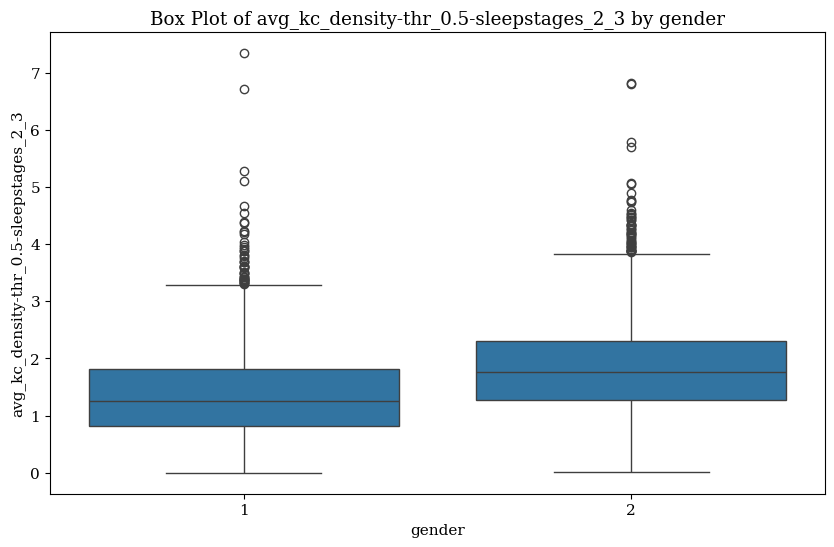

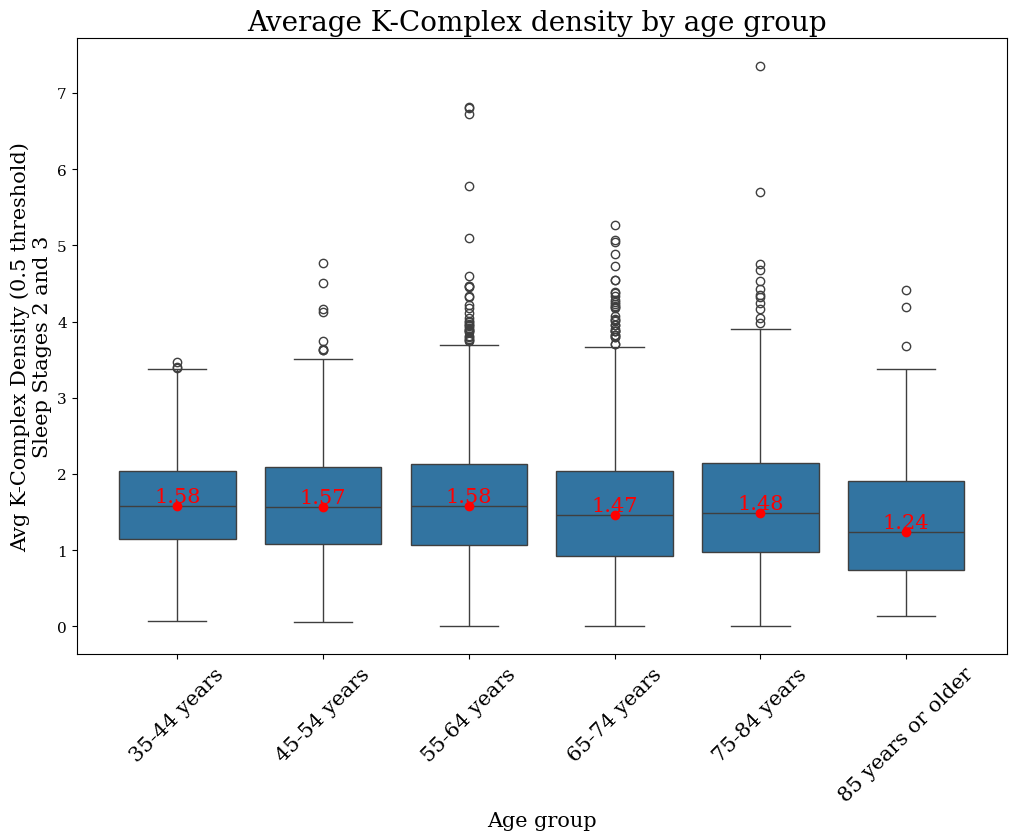

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to create a box plot
def create_box_plot(data, x_feature, y_feature='avg_kc_density-thr_0.7-sleepstages_2_3'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=x_feature, y=y_feature, data=data)
    plt.title(f'Box Plot of {y_feature} by {x_feature}')
    plt.xlabel(x_feature)
    plt.ylabel(y_feature)
    plt.show()
def create_age_box_plot(data, age_feature='age_category_s1', y_feature='avg_kc_density-thr_0.7-sleepstages_2_3'):
    data_copy = data.copy()
    
    # Map the age categories to their labels
    data_copy['age_category_label'] = data_copy[age_feature].map(AGE_LABELS)

    # Ensure the correct order of age categories
    sorted_age_labels = [AGE_LABELS[key] for key in sorted(AGE_LABELS.keys())]
    
    # Create the box plot
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='age_category_label', y=y_feature, data=data_copy, order=sorted_age_labels)
    
    # Calculate and plot the mean for each category
    means = data_copy.groupby('age_category_label')[y_feature].median()
    for i, label in enumerate(sorted_age_labels):
        plt.scatter(i, means[label], color='red', zorder=5)
        plt.text(i, means[label], f'{means[label]:.2f}', ha='center', va='bottom', color='red', fontsize=15)
    
    plt.title(f'Average K-Complex density by age group ', fontsize=20)
    plt.xlabel('Age group', fontsize=15)
    plt.ylabel('Avg K-Complex Density (0.5 threshold)\nSleep Stages 2 and 3', fontsize=15)
    plt.xticks(rotation=45, fontsize=15)  # Rotate labels for better readability
    
    plt.savefig('box_plot_age_category.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Example: Box plot of avg_kc_density by gender
create_box_plot(density_df, x_feature='gender', y_feature='avg_kc_density-thr_0.5-sleepstages_2_3')

# Example: Box plot of avg_kc_density by age category
create_age_box_plot(density_df, y_feature='avg_kc_density-thr_0.5-sleepstages_2_3')

### Testing Wasserstein Barycenters


(102, 384)
Loaded 102 valid KCs
Loaded 359 invalid KCs


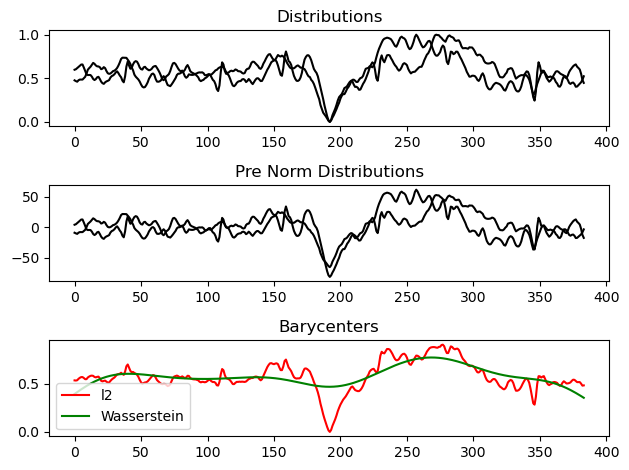

In [13]:
from scipy.ndimage import gaussian_filter1d
from scipy import stats

def normalize_data(data):
    # Normalize the data to be in the range [0, 1]
    min_val = np.min(data, axis=1, keepdims=True)
    max_val = np.max(data, axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

def standardize_data(data):
    mean_val = np.mean(data, axis=1, keepdims=True)
    std_val = np.std(data, axis=1, keepdims=True)
    return (data - mean_val) / std_val

def get_kc_characteristics(index, vis=True):
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')

    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
    
    print(valid_epochs_data_loaded.shape)

    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    print(f'Loaded {labels_valid.shape[0]} valid KCs')
    print(f'Loaded {labels_invalid.shape[0]} invalid KCs')

    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    epochs_data_combined = np.concatenate((valid_epochs_data_loaded, invalid_epochs_data_loaded)) * 10**6
    
    a1_pre = epochs_data_combined[0]
    a2_pre = epochs_data_combined[1]
    A_pre = np.vstack((a1_pre, a2_pre)).T
    
    epochs_data_combined = normalize_data(epochs_data_combined)
    
    # Compute the average KC
    avg_kc = np.mean(epochs_data_combined, axis=0)
    std_kc = np.std(epochs_data_combined, axis=0)
    
    a1 = epochs_data_combined[0]
    a2 = epochs_data_combined[1]
    a3 = epochs_data_combined[2]

    A = np.vstack((a1, a2)).T
    n_distributions = A.shape[1]
    n = A.shape[0]
    weights = np.ones(n_distributions) / n_distributions
    x = np.arange(n, dtype=np.float64)
    
    # loss matrix + normalization
    M = ot.utils.dist0(n)
    M /= M.max()
    
    # l2bary
    bary_l2 = A.dot(weights)

    # wasserstein
    reg = 1e-2  # Increase the regularization parameter
    bary_wass = ot.bregman.barycenter(A, M, reg, weights)

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, tight_layout=True, num=1)
    ax1.plot(x, A, color="black")
    ax1.set_title('Distributions')
    
    ax2.plot(x, A_pre, color="black")
    ax2.set_title('Pre Norm Distributions')

    ax3.plot(x, bary_l2, 'r', label='l2')
    ax3.plot(x, bary_wass, 'g', label='Wasserstein')
    ax3.set_title('Barycenters')

    plt.legend()
    plt.show()
get_kc_characteristics(30)

### Testing K-Means Clustering for Time Seriesimport numpy
A note on preprocessing from here: https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html
-> In this example, time series are preprocessed using TimeSeriesScalerMeanVariance. This scaler is such that each output time series has zero mean and unit variance. The assumption here is that the range of a given time series is uninformative and one only wants to compare shapes in an amplitude-invariant manner (when time series are multivariate, this also rescales all modalities such that there will not be a single modality responsible for a large part of the variance). This means that one cannot scale barycenters back to data range because each time series is scaled independently and there is hence no such thing as an overall data range.

Thus, I don't think it is what we need


In [32]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

index = 100

edf_filename = file_paths[index][0]
annot_filename = file_paths[index][1]
    
kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
# Load the saved EDF files
valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')

valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)

print(valid_epochs_data_loaded.shape)

# Load the stored inference files for valid KCs
labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

# Load the stored inference files for invalid KCs
labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

print(f'Loaded {labels_valid.shape[0]} valid KCs')
print(f'Loaded {labels_invalid.shape[0]} invalid KCs')

# Combine valid and invalid KCs
labels_combined = np.concatenate((labels_valid, labels_invalid))
onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
probas_combined = np.concatenate((probas_valid, probas_invalid))

epochs_data_combined = np.concatenate((valid_epochs_data_loaded, invalid_epochs_data_loaded)) * 10**6

(70, 384)
Loaded 70 valid KCs
Loaded 204 invalid KCs


Euclidean k-means
51.286 --> 26.513 --> 26.513 --> 
DBA k-means
Init 1
20.277 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


9.421 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


9.415 --> 9.415 --> 
Init 2
15.757 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


9.047 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


9.044 --> 9.044 --> 
Soft-DTW k-means


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


499.584 --> 101.621 --> 101.557 --> 101.440 --> 101.408 --> 101.421 --> 101.425 --> 101.422 --> 101.425 --> 101.421 --> 101.425 --> 101.422 --> 101.424 --> 101.422 --> 101.425 --> 101.410 --> 101.447 --> 101.434 --> 101.437 --> 101.433 --> 101.436 --> 101.432 --> 101.435 --> 101.432 --> 101.434 --> 101.431 --> 101.433 --> 101.430 --> 101.432 --> 101.430 --> 101.432 --> 101.430 --> 101.431 --> 101.430 --> 101.431 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 101.430 --> 


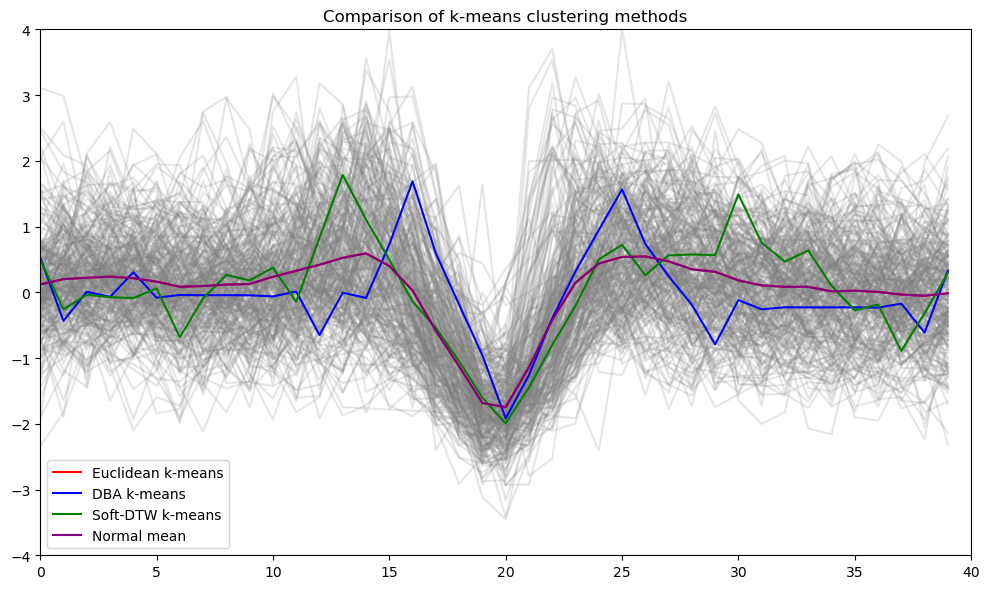

In [33]:
seed = 0
N_CLUSTERS = 1
np.random.seed(seed)

X_train = epochs_data_combined
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)
# Make time series shorter
X_train = TimeSeriesResampler(sz=40).fit_transform(X_train)
sz = X_train.shape[1]

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=N_CLUSTERS, verbose=True, random_state=seed)
y_pred = km.fit_predict(X_train)
euclidean_centers = km.cluster_centers_

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(X_train)
dba_centers = dba_km.cluster_centers_

# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=N_CLUSTERS,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = sdtw_km.fit_predict(X_train)
sdtw_centers = sdtw_km.cluster_centers_

# Normal mean
normal_mean = np.mean(X_train, axis=0)

# Plot all results in a single plot with unique colors
plt.figure(figsize=(10, 6))

# Plot original time series in light gray
for xx in X_train:
    plt.plot(xx.ravel(), color="gray", alpha=0.2)

# Plot cluster centers and normal mean with different colors
plt.plot(euclidean_centers[0].ravel(), color="red", label="Euclidean k-means")
plt.plot(dba_centers[0].ravel(), color="blue", label="DBA k-means")
plt.plot(sdtw_centers[0].ravel(), color="green", label="Soft-DTW k-means")
plt.plot(normal_mean.ravel(), color="purple", label="Normal mean")

plt.xlim(0, sz)
plt.ylim(-4, 4)
plt.title("Comparison of k-means clustering methods")
plt.legend()
plt.tight_layout()
plt.show()

### Characterise the KC
Average with mean or wasserstein
- [x] FFT Features
    - P1 – total power within the span of [0.0; 3.5] Hz,
    - P2 – total power within the span of [1.0; 4.5] Hz,
    - P3 – total power within the span of [2.0; 5.5] Hz,
    - P4 – total power within the span of [3.0; 6.5] Hz,
- [x] Average Density
- [x] Duration min to max
- [x] Duration
- [x] Minimum Amplitude: avg, std, min, max 
- [x] Maximum Amplitude: avg, std, min, max 
- [x] Std of mean

Executing for index  10
/home/ec2-user/SageMaker/datasets/nsrr/shhs/preprocessed/shhs1/shhs1-200011/invalid_kcs/edfs
Valid epochs data:  (348, 384)
Invalid epochs data:  (176, 384)
After thresholding:  (524, 384)
After sleep stage filtering:  (524, 384)
(524, 384)


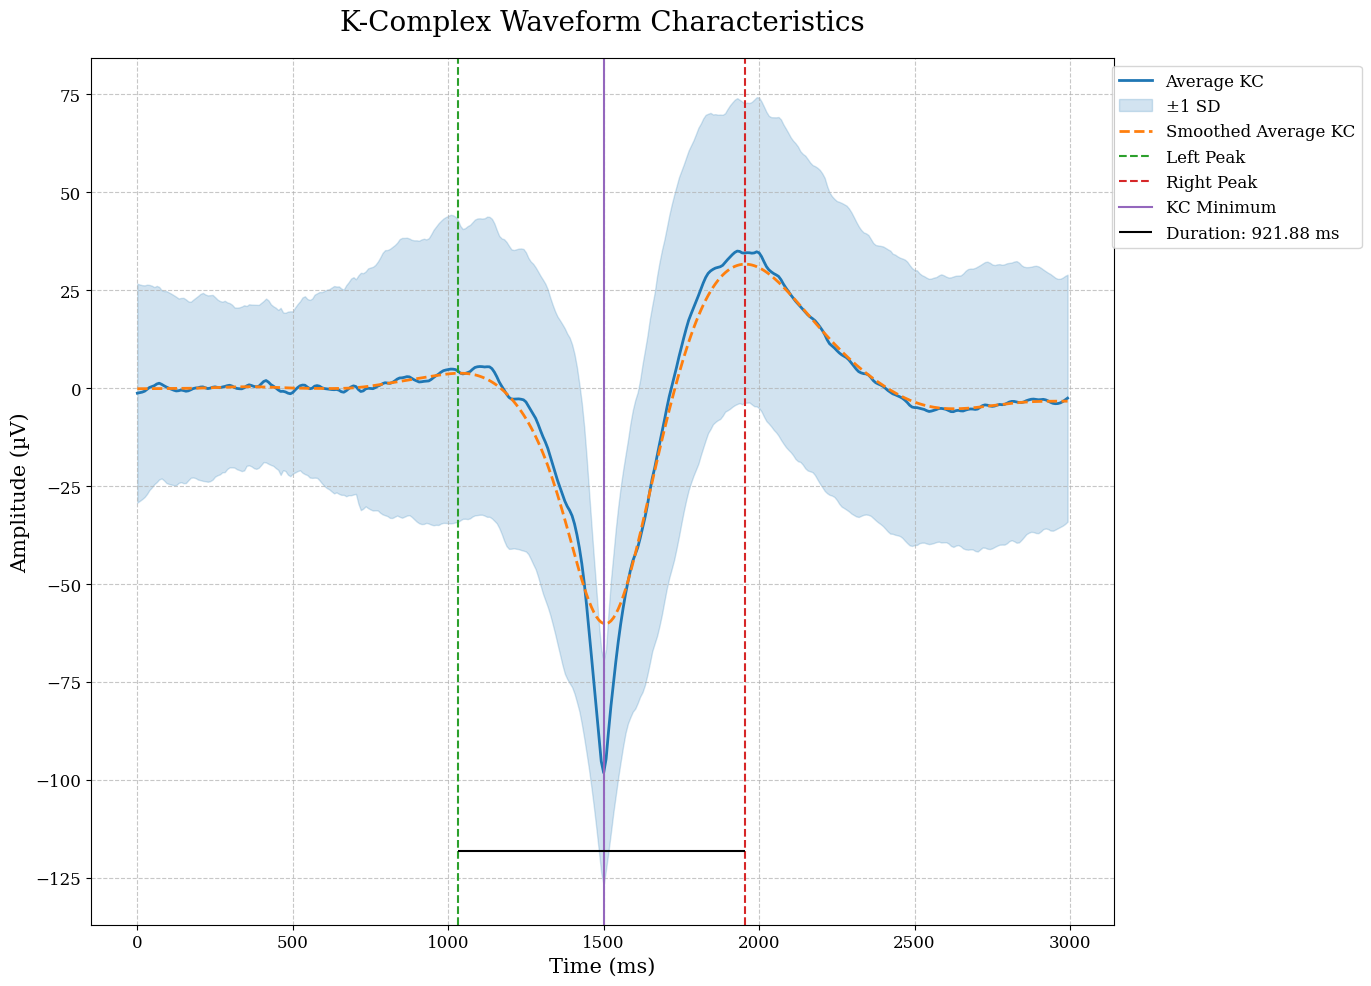

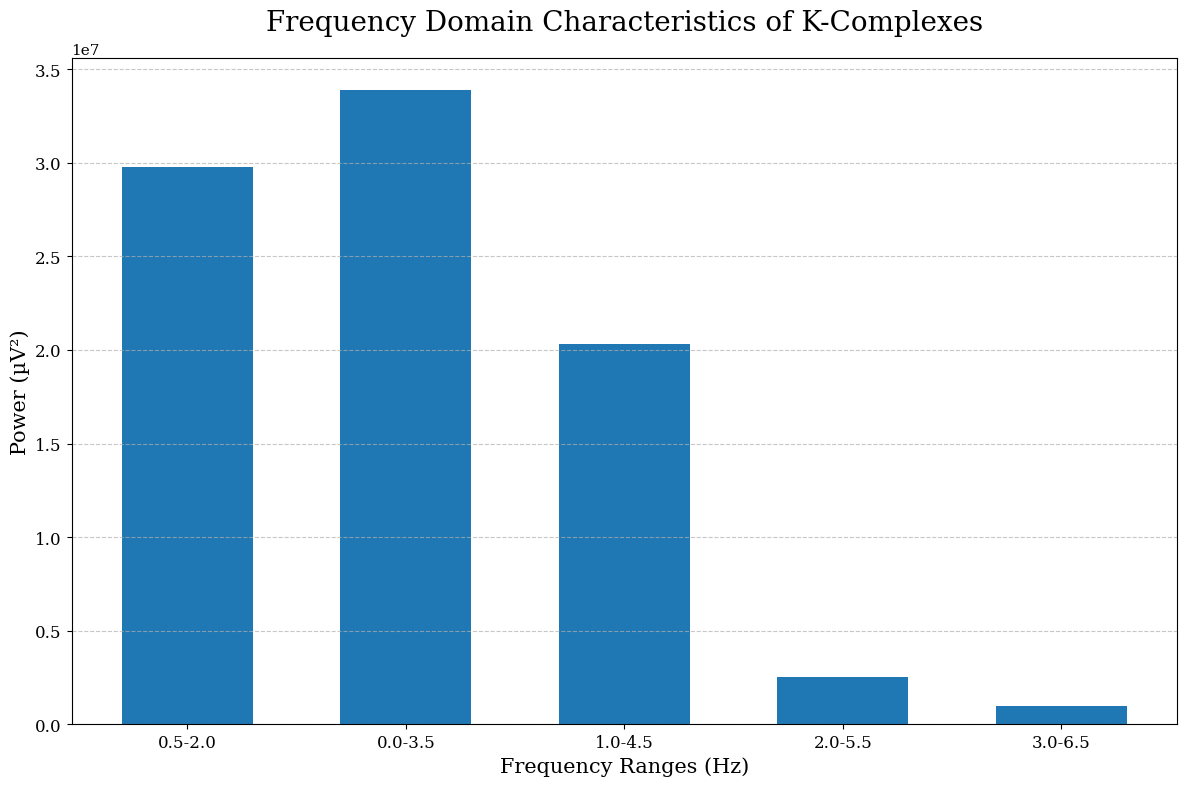

{'avg_std_kc': 34.08464599504106,
 'global_min_value': -98.16000849503874,
 'global_min_index': 192,
 'global_min_std': 28.725087005082617,
 'global_min_min_value': -241.317,
 'global_min_max_value': -17.850116767479474,
 'min_max_duration': 0.453125,
 'max_max_duration': 0.921875,
 'variance_duration': 1.6015625,
 'right_peak_value': 34.95917452558744,
 'right_peak_index': 247,
 'right_peak_std': 39.01723710795855,
 'right_peak_min_value': -154.10412591631825,
 'right_peak_max_value': 166.42852180242318,
 'left_peak_value': 5.501732228201513,
 'left_peak_index': 141,
 'left_peak_std': 37.81952928068827,
 'left_peak_min_value': -217.2615058003479,
 'left_peak_max_value': 161.1866525650807,
 'fft_feature_05_2': 29768214.523266546,
 'fft_feature_0_35': 33927536.09177103,
 'fft_feature_1_45': 20336131.467601012,
 'fft_feature_2_55': 2508791.172771289,
 'fft_feature_3_65': 952685.1021312699}

In [13]:
# TODO: Sleep stages filtering!

def compute_fft_features(data, sampling_freq):
    # Perform FFT
    N = len(data)
    yf = fft(data)
    
    xf = fftfreq(N, 1 / sampling_freq)[:N // 2]
    
    # Compute power spectral density
    psd = np.abs(yf[:N // 2])**2

    # Define frequency ranges
    freq_ranges = [(0.5, 2.0), (0.0, 3.5), (1.0, 4.5), (2.0, 5.5), (3.0, 6.5)]
    power_features = []

    for f_min, f_max in freq_ranges:
        mask = (xf >= f_min) & (xf <= f_max)
        power = np.sum(psd[mask])
        power_features.append(power)
    
    return power_features

def get_kc_characteristics(index, vis=True, smoothing_sigma=10, threshold=0.5, sleep_stages=[2,3]):
    print("Executing for index ", index)
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')
    
    print(invalid_edf_output_dir)
    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
    
    # Ensure dimensions - if data only has one KC it is returned 1D
    valid_epochs_data_loaded = np.atleast_2d(valid_epochs_data_loaded)
    invalid_epochs_data_loaded = np.atleast_2d(invalid_epochs_data_loaded)
    
    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    print("Valid epochs data: ", valid_epochs_data_loaded.shape)
    print("Invalid epochs data: ", invalid_epochs_data_loaded.shape)
    if valid_epochs_data_loaded.shape[1] != 0 and invalid_epochs_data_loaded.shape[1] != 0:
        epochs_data_combined = np.concatenate((valid_epochs_data_loaded, invalid_epochs_data_loaded)) * 10**6
    elif valid_epochs_data_loaded.shape[1] != 0 and invalid_epochs_data_loaded.shape[1] == 0:
        epochs_data_combined = valid_epochs_data_loaded * 10**6
    else:
        epochs_data_combined = invalid_epochs_data_loaded * 10**6
        
    # Only select the KCs that correspond to probas with more than threshold
    thresholded_onsets = onsets_combined[probas_combined > threshold]
    epochs_data_combined = epochs_data_combined[probas_combined > threshold]
    print("After thresholding: ", epochs_data_combined.shape)
        
    # Only select the KCs that fall into a sleep stage that we want
    stages = import_event_and_stages_SHHS(annot_filename)[1]
    filtered_onsets, removed_onsets = filter_kcs_by_sleep_stages(thresholded_onsets, stages, sleep_stages, SAMPLING_FREQ)
    epochs_data_combined = epochs_data_combined[np.isin(thresholded_onsets, filtered_onsets)]
    print("After sleep stage filtering: ", epochs_data_combined.shape)
    
    print(epochs_data_combined.shape)
    # Compute the average KC
    if epochs_data_combined.shape[0] > 5:
        avg_kc = np.mean(epochs_data_combined, axis=0)
        std_kc = np.std(epochs_data_combined, axis=0)
        min_kc = np.min(epochs_data_combined, axis=0)
        max_kc = np.max(epochs_data_combined, axis=0)
        avg_std_kc = np.mean(std_kc)

        # Step 1: Find the minimum in the average KC
        min_index = np.argmin(avg_kc)
        min_value = avg_kc[min_index]
        min_std = std_kc[min_index]
        min_min_value = min_kc[min_index]
        min_max_value = max_kc[min_index]

        # Step 2: Smooth the average KC heavily & find the derivative
        smoothed_avg_kc = gaussian_filter1d(avg_kc, sigma=smoothing_sigma)
        derivative = np.gradient(smoothed_avg_kc)

        # Step 3: Find the min-max duration
        zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
        min_diff = np.abs(zero_crossings - min_index)
        min_diff_index = np.argmin(min_diff)
        right_duration_index = zero_crossings[min_diff_index + 1] if len(zero_crossings) - 1 >= min_diff_index + 1 else len(smoothed_avg_kc) - 1
        left_duration_index = zero_crossings[min_diff_index - 1] if min_diff_index - 1 >= 0 else 0

        min_max_duration = (right_duration_index - min_index) / SAMPLING_FREQ
        max_max_duration = (right_duration_index - left_duration_index) / SAMPLING_FREQ

        # Step 4: Calculate variance based duration
        window_size = 50  # Define window size
        var_kc = np.array([np.var(smoothed_avg_kc[i:i+window_size]) for i in range(len(smoothed_avg_kc) - window_size + 1)])
        var_kc = np.pad(var_kc, (window_size//2, window_size//2 - 1), 'edge')  # Pad to match original length

        # Use a threshold to determine the end of the K-Complex
        threshold = 2  # Define threshold as half the mean variance
        left_var_duration_index = np.where(var_kc[:min_index] < threshold)[0][-1] if len(np.where(var_kc[:min_index] < threshold)[0]) > 0 else 0
        right_var_duration_index = np.where(var_kc[min_index:] < threshold)[0][0] + min_index if len(np.where(var_kc[min_index:] < threshold)[0]) > 0 else len(smoothed_avg_kc) - 1
        variance_duration = (right_var_duration_index - left_var_duration_index) / SAMPLING_FREQ

        # Step 5: Find the right side peak in the average KC
        right_peak_index = min_index + np.argmax(avg_kc[min_index:])
        right_peak_value = avg_kc[right_peak_index]
        right_peak_std = std_kc[right_peak_index]
        right_peak_min_value = min_kc[right_peak_index]
        right_peak_max_value = max_kc[right_peak_index]

        # Step 6: Find the left side peak in the average KC
        left_peak_index = np.argmax(avg_kc[:min_index])
        left_peak_value = avg_kc[left_peak_index]
        left_peak_std = std_kc[left_peak_index]
        left_peak_min_value = min_kc[left_peak_index]
        left_peak_max_value = max_kc[left_peak_index]

        # Step 7: Compute FFT features
        fft_features = compute_fft_features(avg_kc, SAMPLING_FREQ)
    
        # Plot both the avg_kc with std_kc, the smoothed_avg_kc, and the derivative
        if vis:
            # Improved KC Characteristics Plot
            plt.figure(figsize=(14, 10))
            
            time = np.arange(len(avg_kc)) / SAMPLING_FREQ * 1000  # Convert to milliseconds
            
            plt.plot(time, avg_kc, label='Average KC', color='#1f77b4', linewidth=2)
            plt.fill_between(time, avg_kc - std_kc, avg_kc + std_kc, color='#1f77b4', alpha=0.2, label='±1 SD')
            plt.plot(time, smoothed_avg_kc, label='Smoothed Average KC', color='#ff7f0e', linestyle='--', linewidth=2)
            
            plt.axvline(x=time[left_duration_index], color='#2ca02c', linestyle='--', label='Left Peak')
            plt.axvline(x=time[right_duration_index], color='#d62728', linestyle='--', label='Right Peak')
            plt.axvline(x=time[min_index], color='#9467bd', linestyle='-', label='KC Minimum')
            
            duration = time[right_duration_index] - time[left_duration_index]
            plt.hlines(y=np.min(avg_kc) - 20, xmin=time[left_duration_index], xmax=time[right_duration_index], 
                       colors='k', linestyles='-', label=f'Duration: {duration:.2f} ms')
            
            plt.title('K-Complex Waveform Characteristics', fontsize=20, pad=20)
            plt.xlabel('Time (ms)', fontsize=15)
            plt.ylabel('Amplitude (µV)', fontsize=15)
            
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            
            plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1.25, 1))
            plt.grid(linestyle='--', alpha=0.7)
            
            plt.tight_layout()
            
            # Save the plot as a PDF
            plt.savefig('improved_kc_characteristics.pdf', format='pdf', bbox_inches='tight')
            plt.show()

            # Improved FFT Features Plot
            plt.figure(figsize=(12, 8))
            freq_ranges = ['0.5-2.0', '0.0-3.5', '1.0-4.5', '2.0-5.5', '3.0-6.5']
            
            bars = plt.bar(freq_ranges, fft_features, color='#1f77b4', width=0.6)
            
            plt.title('Frequency Domain Characteristics of K-Complexes', fontsize=20, pad=20)
            plt.xlabel('Frequency Ranges (Hz)', fontsize=15)
            plt.ylabel('Power (µV²)', fontsize=15)
            
            plt.xticks(fontsize=12)
            plt.yticks(fontsize=12)
            
            # Add value labels on top of each bar
            #for bar in bars:
            #    height = bar.get_height()
            #    plt.text(bar.get_x() + bar.get_width()/2., height,
            #             f'{height:.2e}',
            #             ha='center', va='bottom', fontsize=10, rotation=0)
            
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            
            # Save the plot as a PDF
            plt.savefig('improved_fft_features.pdf', format='pdf', bbox_inches='tight')
            plt.show()

        kc_characteristics = {
            'avg_std_kc': avg_std_kc,
            'global_min_value': min_value,
            'global_min_index': min_index,
            'global_min_std': min_std,
            'global_min_min_value': min_min_value,
            'global_min_max_value': min_max_value,
            'min_max_duration': min_max_duration,
            'max_max_duration': max_max_duration,
            'variance_duration': variance_duration,
            'right_peak_value': right_peak_value,
            'right_peak_index': right_peak_index,
            'right_peak_std': right_peak_std,
            'right_peak_min_value': right_peak_min_value,
            'right_peak_max_value': right_peak_max_value,
            'left_peak_value': left_peak_value,
            'left_peak_index': left_peak_index,
            'left_peak_std': left_peak_std,
            'left_peak_min_value': left_peak_min_value,
            'left_peak_max_value': left_peak_max_value,
            'fft_feature_05_2': fft_features[0],
            'fft_feature_0_35': fft_features[1],
            'fft_feature_1_45': fft_features[2],
            'fft_feature_2_55': fft_features[3],
            'fft_feature_3_65': fft_features[4],
        }
    else:
        print("No datapoints")
    
        kc_characteristics = {
            'avg_std_kc': np.nan,
            'global_min_value': np.nan,
            'global_min_index': np.nan,
            'global_min_std': np.nan,
            'global_min_min_value': np.nan,
            'global_min_max_value': np.nan,
            'min_max_duration': np.nan,
            'max_max_duration': np.nan,
            'variance_duration': np.nan,
            'right_peak_value': np.nan,
            'right_peak_index': np.nan,
            'right_peak_std': np.nan,
            'right_peak_min_value': np.nan,
            'right_peak_max_value': np.nan,
            'left_peak_value': np.nan,
            'left_peak_index': np.nan,
            'left_peak_std': np.nan,
            'left_peak_min_value': np.nan,
            'left_peak_max_value': np.nan,
            'fft_feature_05_2': np.nan,
            'fft_feature_0_35': np.nan,
            'fft_feature_1_45': np.nan,
            'fft_feature_2_55': np.nan,
            'fft_feature_3_65': np.nan,
        }
    
    return kc_characteristics

get_kc_characteristics(10, threshold=0.5, sleep_stages=[2,3], vis=True)

### Function optimised for multiprocessing over full dataset

In [15]:
def get_kc_characteristics(index, smoothing_sigmas, thresholds, wanted_sleep_stages):
    edf_filename = file_paths[index][0]
    annot_filename = file_paths[index][1]
    
    kc_dir = os.path.join(kcs_dir, os.path.basename(edf_filename).replace('.edf', ''))
    # Load the saved EDF files
    valid_edf_output_dir = os.path.join(kc_dir, 'valid_kcs', 'edfs')
    invalid_edf_output_dir = os.path.join(kc_dir, 'invalid_kcs', 'edfs')

    valid_epochs_data_loaded = load_kcs_edf_files(valid_edf_output_dir)
    invalid_epochs_data_loaded = load_kcs_edf_files(invalid_edf_output_dir)
        
    # Ensure dimensions - if data only has one KC it is returned 1D
    valid_epochs_data_loaded = np.atleast_2d(valid_epochs_data_loaded)
    invalid_epochs_data_loaded = np.atleast_2d(invalid_epochs_data_loaded)

    # Load the stored inference files for valid KCs
    labels_valid, onsets_valid, probas_valid = load_valid_kc_metadata(kc_dir)

    # Load the stored inference files for invalid KCs
    labels_invalid, onsets_invalid, probas_invalid = load_invalid_kc_metadata(kc_dir)

    # Combine valid and invalid KCs
    labels_combined = np.concatenate((labels_valid, labels_invalid))
    onsets_combined = np.concatenate((onsets_valid, onsets_invalid))
    probas_combined = np.concatenate((probas_valid, probas_invalid))
    
    if valid_epochs_data_loaded.shape[1] != 0 and invalid_epochs_data_loaded.shape[1] != 0:
        epochs_data_combined = np.concatenate((valid_epochs_data_loaded, invalid_epochs_data_loaded)) * 10**6
    elif valid_epochs_data_loaded.shape[1] != 0 and invalid_epochs_data_loaded.shape[1] == 0:
        epochs_data_combined = valid_epochs_data_loaded * 10**6
    else:
        epochs_data_combined = invalid_epochs_data_loaded * 10**6
    
    kc_characteristics = {}
    
    for threshold in thresholds:
        for sleep_stage in wanted_sleep_stages:
            for sigma in smoothing_sigmas:
                name_prefix = f'thr_{threshold}-sleepstages_{"_".join(map(str, sleep_stage))}-smoothing_{sigma}'
                
                # Only select the KCs that correspond to probas with more than threshold
                thresholded_onsets = onsets_combined[probas_combined > threshold]
                epochs_data_combined_thresh = epochs_data_combined[probas_combined > threshold]
                
                # Only select the KCs that fall into a sleep stage that we want
                stages = import_event_and_stages_SHHS(annot_filename)[1]
                filtered_onsets, _ = filter_kcs_by_sleep_stages(thresholded_onsets, stages, sleep_stage, SAMPLING_FREQ)

                
                # Filter epochs_data_combined accordingly
                epochs_data_combined_final = epochs_data_combined_thresh[np.isin(thresholded_onsets, filtered_onsets)]
                
                if epochs_data_combined_final.shape[0] > 5:
                    # Compute the average KC
                    avg_kc = np.mean(epochs_data_combined_final, axis=0)
                    std_kc = np.std(epochs_data_combined_final, axis=0)
                    min_kc = np.min(epochs_data_combined_final, axis=0)
                    max_kc = np.max(epochs_data_combined_final, axis=0)
                    avg_std_kc = np.mean(std_kc)

                    # Step 1: Find the minimum in the average KC
                    min_index = np.argmin(avg_kc)
                    min_value = avg_kc[min_index]
                    min_std = std_kc[min_index]
                    min_min_value = min_kc[min_index]
                    min_max_value = max_kc[min_index]

                    # Step 2: Smooth the average KC heavily & find the derivative
                    smoothed_avg_kc = gaussian_filter1d(avg_kc, sigma=sigma)
                    derivative = np.gradient(smoothed_avg_kc)

                    # Step 3: Find the min-max duration
                    zero_crossings = np.where(np.diff(np.sign(derivative)))[0]
                    min_diff = np.abs(zero_crossings - min_index)
                    min_diff_index = np.argmin(min_diff)
                    right_duration_index = zero_crossings[min_diff_index + 1] if len(zero_crossings) - 1 >= min_diff_index + 1 else len(smoothed_avg_kc) - 1
                    left_duration_index = zero_crossings[min_diff_index - 1] if min_diff_index - 1 >= 0 else 0

                    min_max_duration = (right_duration_index - min_index) / SAMPLING_FREQ
                    max_max_duration = (right_duration_index - left_duration_index) / SAMPLING_FREQ

                    # Step 4: Calculate variance based duration
                    window_size = 50  # Define window size
                    var_kc = np.array([np.var(smoothed_avg_kc[i:i+window_size]) for i in range(len(smoothed_avg_kc) - window_size + 1)])
                    var_kc = np.pad(var_kc, (window_size//2, window_size//2 - 1), 'edge')  # Pad to match original length

                    # Use a threshold to determine the end of the K-Complex
                    variance_threshold = 2  # Define threshold as half the mean variance
                    left_var_duration_index = np.where(var_kc[:min_index] < variance_threshold)[0][-1] if len(np.where(var_kc[:min_index] < variance_threshold)[0]) > 0 else 0
                    right_var_duration_index = np.where(var_kc[min_index:] < variance_threshold)[0][0] + min_index if len(np.where(var_kc[min_index:] < variance_threshold)[0]) > 0 else len(smoothed_avg_kc) - 1
                    variance_duration = (right_var_duration_index - left_var_duration_index) / SAMPLING_FREQ

                    # Step 5: Find the right side peak in the average KC
                    right_peak_index = min_index + np.argmax(avg_kc[min_index:])
                    right_peak_value = avg_kc[right_peak_index]
                    right_peak_std = std_kc[right_peak_index]
                    right_peak_min_value = min_kc[right_peak_index]
                    right_peak_max_value = max_kc[right_peak_index]

                    # Step 6: Find the left side peak in the average KC
                    left_peak_index = np.argmax(avg_kc[:min_index])
                    left_peak_value = avg_kc[left_peak_index]
                    left_peak_std = std_kc[left_peak_index]
                    left_peak_min_value = min_kc[left_peak_index]
                    left_peak_max_value = max_kc[left_peak_index]

                    # Step 7: Compute FFT features
                    fft_features = compute_fft_features(avg_kc, SAMPLING_FREQ)

                    # Store the results in the kc_characteristics dictionary
                    kc_characteristics[f'avg_std_kc-{name_prefix}'] = avg_std_kc
                    kc_characteristics[f'global_min_value-{name_prefix}'] = min_value
                    kc_characteristics[f'global_min_index-{name_prefix}'] = min_index
                    kc_characteristics[f'global_min_std-{name_prefix}'] = min_std
                    kc_characteristics[f'global_min_min_value-{name_prefix}'] = min_min_value
                    kc_characteristics[f'global_min_max_value-{name_prefix}'] = min_max_value
                    kc_characteristics[f'min_max_duration-{name_prefix}'] = min_max_duration
                    kc_characteristics[f'max_max_duration-{name_prefix}'] = max_max_duration
                    kc_characteristics[f'variance_duration-{name_prefix}'] = variance_duration
                    kc_characteristics[f'right_peak_value-{name_prefix}'] = right_peak_value
                    kc_characteristics[f'right_peak_index-{name_prefix}'] = right_peak_index
                    kc_characteristics[f'right_peak_std-{name_prefix}'] = right_peak_std
                    kc_characteristics[f'right_peak_min_value-{name_prefix}'] = right_peak_min_value
                    kc_characteristics[f'right_peak_max_value-{name_prefix}'] = right_peak_max_value
                    kc_characteristics[f'left_peak_value-{name_prefix}'] = left_peak_value
                    kc_characteristics[f'left_peak_index-{name_prefix}'] = left_peak_index
                    kc_characteristics[f'left_peak_std-{name_prefix}'] = left_peak_std
                    kc_characteristics[f'left_peak_min_value-{name_prefix}'] = left_peak_min_value
                    kc_characteristics[f'left_peak_max_value-{name_prefix}'] = left_peak_max_value
                    kc_characteristics[f'fft_feature_05_2-{name_prefix}'] = fft_features[0]
                    kc_characteristics[f'fft_feature_0_35-{name_prefix}'] = fft_features[1]
                    kc_characteristics[f'fft_feature_1_45-{name_prefix}'] = fft_features[2]
                    kc_characteristics[f'fft_feature_2_55-{name_prefix}'] = fft_features[3]
                    kc_characteristics[f'fft_feature_3_65-{name_prefix}'] = fft_features[4]
                else:
                    kc_characteristics[f'avg_std_kc-{name_prefix}'] = np.nan
                    kc_characteristics[f'global_min_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'global_min_index-{name_prefix}'] = np.nan
                    kc_characteristics[f'global_min_std-{name_prefix}'] = np.nan
                    kc_characteristics[f'global_min_min_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'global_min_max_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'min_max_duration-{name_prefix}'] = np.nan
                    kc_characteristics[f'max_max_duration-{name_prefix}'] = np.nan
                    kc_characteristics[f'variance_duration-{name_prefix}'] = np.nan
                    kc_characteristics[f'right_peak_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'right_peak_index-{name_prefix}'] = np.nan
                    kc_characteristics[f'right_peak_std-{name_prefix}'] = np.nan
                    kc_characteristics[f'right_peak_min_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'right_peak_max_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'left_peak_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'left_peak_index-{name_prefix}'] = np.nan
                    kc_characteristics[f'left_peak_std-{name_prefix}'] = np.nan
                    kc_characteristics[f'left_peak_min_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'left_peak_max_value-{name_prefix}'] = np.nan
                    kc_characteristics[f'fft_feature_05_2-{name_prefix}'] = np.nan
                    kc_characteristics[f'fft_feature_0_35-{name_prefix}'] = np.nan
                    kc_characteristics[f'fft_feature_1_45-{name_prefix}'] = np.nan
                    kc_characteristics[f'fft_feature_2_55-{name_prefix}'] = np.nan
                    kc_characteristics[f'fft_feature_3_65-{name_prefix}'] = np.nan
        
    return kc_characteristics

In [392]:
population_selected_df_subset.head()

,index,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity
0,0,200001,21.777553,1,178.0,65.0,86.0,7,92.842202,85.0,2
1,1,200002,32.950680,1,168.0,93.0,107.0,9,94.324476,82.0,2
2,2,200003,24.114150,2,145.0,51.0,82.0,9,95.417794,82.0,2
3,3,200004,20.185185,1,180.0,64.0,85.0,6,95.966722,92.0,2
4,4,200005,23.309053,2,155.0,56.0,76.0,8,94.603517,83.0,2


In [ ]:
### Iterate over the following combination
thresholds = [0.5, 0.7, 0.8, 0.9]
wanted_sleep_stages = [[2], [3], [2, 3]]
smoothing_sigmas = [5, 10, 20]


# Wrapper function to use tqdm with Pool
def pool_map_with_progress(func, iterable, n_jobs, desc="Processing"):
    with Pool(n_jobs) as pool:
        result = list(tqdm(pool.imap(func, iterable), total=len(iterable), desc=desc))
    return result

# Parallel processing function
def parallel_process(df, func, n_jobs=4):
    return pool_map_with_progress(func, df.index, n_jobs, desc="Calculating KC density")

def processing_function(index):
    return get_kc_characteristics(index, smoothing_sigmas, thresholds, wanted_sleep_stages)

def add_results_to_dataframe(df, results):
    for i, res in enumerate(results):
        for key, value in res.items():
            df.loc[i, key] = value
    return df

# Assuming 'population_selected_df_subset' and 'file_paths' are defined
results = parallel_process(population_selected_df_subset, processing_function, n_jobs=8)
updated_df = add_results_to_dataframe(population_selected_df_subset, results)

updated_df.to_csv(kc_features_dataset)
updated_df.head()

Calculating KC density: 100%|██████████| 5793/5793 [6:28:46<00:00,  4.03s/it]   


,index,nsrrid,bmi_s1,gender,height,weight,waist,age_category_s1,avgsat,minsat,ethnicity,avg_std_kc-thr_0.5-sleepstages_2-smoothing_5,global_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_index-thr_0.5-sleepstages_2-smoothing_5,global_min_std-thr_0.5-sleepstages_2-smoothing_5,global_min_min_value-thr_0.5-sleepstages_2-smoothing_5,global_min_max_value-thr_0.5-sleepstages_2-smoothing_5,min_max_duration-thr_0.5-sleepstages_2-smoothing_5,max_max_duration-thr_0.5-sleepstages_2-smoothing_5,variance_duration-thr_0.5-sleepstages_2-smoothing_5,right_peak_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_index-thr_0.5-sleepstages_2-smoothing_5,right_peak_std-thr_0.5-sleepstages_2-smoothing_5,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_index-thr_0.5-sleepstages_2-smoothing_5,left_peak_std-thr_0.5-sleepstages_2-smoothing_5,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_5,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_5,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_5,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_5,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_5,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_5,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_5,avg_std_kc-thr_0.5-sleepstages_2-smoothing_10,global_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_index-thr_0.5-sleepstages_2-smoothing_10,global_min_std-thr_0.5-sleepstages_2-smoothing_10,global_min_min_value-thr_0.5-sleepstages_2-smoothing_10,global_min_max_value-thr_0.5-sleepstages_2-smoothing_10,min_max_duration-thr_0.5-sleepstages_2-smoothing_10,max_max_duration-thr_0.5-sleepstages_2-smoothing_10,variance_duration-thr_0.5-sleepstages_2-smoothing_10,right_peak_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_index-thr_0.5-sleepstages_2-smoothing_10,right_peak_std-thr_0.5-sleepstages_2-smoothing_10,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_index-thr_0.5-sleepstages_2-smoothing_10,left_peak_std-thr_0.5-sleepstages_2-smoothing_10,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_10,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_10,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_10,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_10,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_10,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_10,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_10,avg_std_kc-thr_0.5-sleepstages_2-smoothing_20,global_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_index-thr_0.5-sleepstages_2-smoothing_20,global_min_std-thr_0.5-sleepstages_2-smoothing_20,global_min_min_value-thr_0.5-sleepstages_2-smoothing_20,global_min_max_value-thr_0.5-sleepstages_2-smoothing_20,min_max_duration-thr_0.5-sleepstages_2-smoothing_20,max_max_duration-thr_0.5-sleepstages_2-smoothing_20,variance_duration-thr_0.5-sleepstages_2-smoothing_20,right_peak_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_index-thr_0.5-sleepstages_2-smoothing_20,right_peak_std-thr_0.5-sleepstages_2-smoothing_20,right_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,right_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_index-thr_0.5-sleepstages_2-smoothing_20,left_peak_std-thr_0.5-sleepstages_2-smoothing_20,left_peak_min_value-thr_0.5-sleepstages_2-smoothing_20,left_peak_max_value-thr_0.5-sleepstages_2-smoothing_20,fft_feature_05_2-thr_0.5-sleepstages_2-smoothing_20,fft_feature_0_35-thr_0.5-sleepstages_2-smoothing_20,fft_feature_1_45-thr_0.5-sleepstages_2-smoothing_20,fft_feature_2_55-thr_0.5-sleepstages_2-smoothing_20,fft_feature_3_65-thr_0.5-sleepstages_2-smoothing_20,avg_std_kc-thr_0.5-sleepstages_3-smoothing_5,global_min_value-thr_0.5-sleepstages_3-smoothing_5,global_min_index-thr_0.5-sleepstages_3-smoothing_5,global_min_std-thr_0.

In [ ]:
updated_df.head()